In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Base Notebook to re-create figures of _

This notebook is the base notebook for 10X's Xenium brain showcase tissue sample. It runs the standard ovrlpy pipeline and saves the results to be used in further analysis.

In [101]:
from pathlib import Path

data_folder_path = Path("/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1")


### Data loader:

In [102]:
import pandas as  pd

coordinate_df = pd.read_parquet(data_folder_path/"transcripts.parquet")
coordinate_df["feature_name"]=coordinate_df.feature_name.str.decode("utf-8")

# remove dummy molecules:
dummy_mask = (coordinate_df.feature_name.str.contains('BLANK') | coordinate_df.feature_name.str.contains('NegControl'))
coordinate_df = coordinate_df[~dummy_mask]

# format columns:
coordinate_df = coordinate_df[['x_location','y_location','z_location','feature_name','cell_id','overlaps_nucleus','qv']]
coordinate_df.columns = ['x','y','z','gene','cell_id','overlaps_nucleus','qv']
coordinate_df['gene'] = coordinate_df['gene'].astype("category")

print(f"Number of cells: {coordinate_df.cell_id.nunique()}",f"Number of genes: {coordinate_df.gene.nunique()}",f"Number of molecules: {coordinate_df.shape[0]}",sep="\n")

Number of cells: 162034
Number of genes: 248
Number of molecules: 62384369


### Run the basic ovrlppy pipeline:

We expect a roughly estimated 30 cell types in the sample. For the remaining parameters, we use the default values.

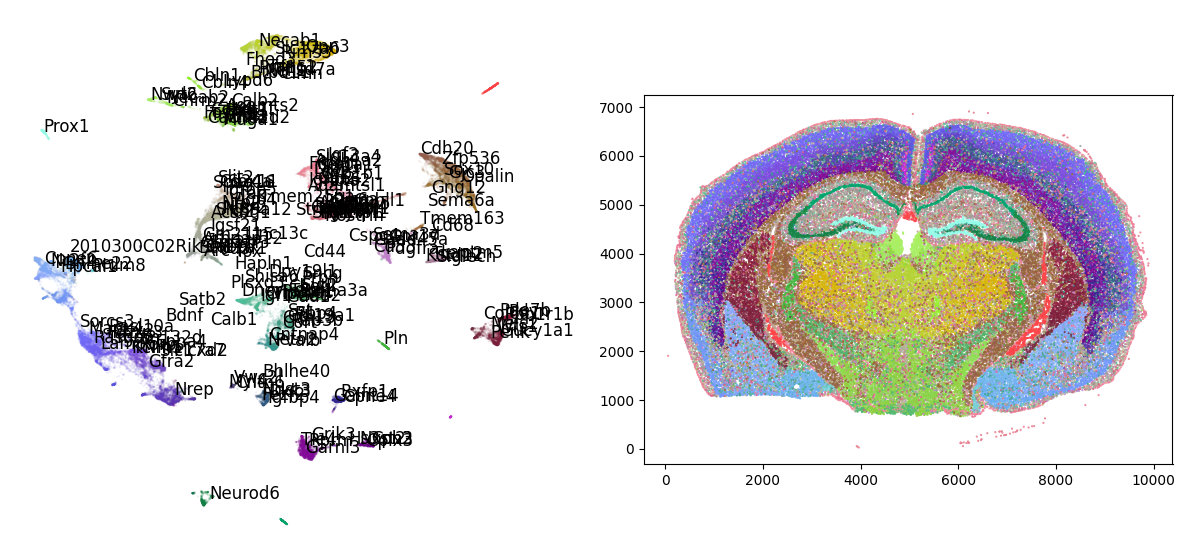

In [103]:
import ovrlpy

visualizer = ovrlpy.load_visualizer('./publication/xenium-brain/xenium-brain.vis')

signal_integrity,signal_strength = visualizer.integrity_map,visualizer.signal_map

visualizer.plot_fit()

In [107]:
np.array([200,1200,1200,2200])*2

array([ 400, 2400, 2400, 4400])

### UMAP annotation using external gene expression signatures:

We can use external gene expression signatures to annotate the UMAP. In this case, we use cell features extracted from the allen brain atlas (REF):

/tmp/ipykernel_2955955/1313902892.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fold_bottom_centroids = fold_df_bottom[fold_df_bottom.overlaps_nucleus==1].groupby("cell_id").apply(lambda x: x[['x','y']].mean()).astype(int)
/tmp/ipykernel_2955955/1313902892.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fold_top_centroids = fold_df_top[fold_df_top.overlaps_nucleus==1].groupby("cell_id").apply(la

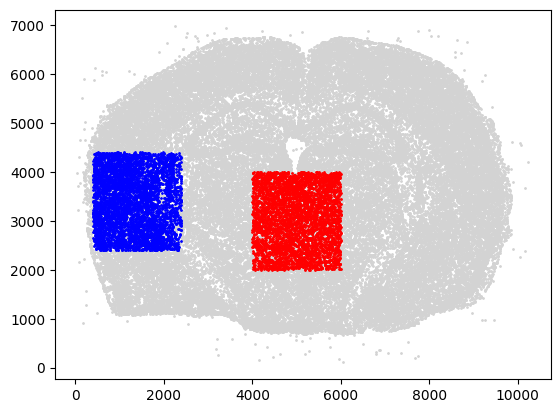

In [110]:
import matplotlib.pyplot as plt

# crop out a central part of the tissue to create artificial overlaps:
xb_,_xb,yb_,_yb = 4000, 6000, 2000, 4000
xt_,_xt,yt_,_yt = 400, 2400, 2400, 4400
fold_bottom_mask = coordinate_df.x.between(xb_,_xb)&coordinate_df.y.between(yb_,_yb)
fold_top_mask = coordinate_df.x.between(xt_,_xt)&coordinate_df.y.between(yt_,_yt)

fold_df_bottom = coordinate_df[fold_bottom_mask].copy()
fold_df_bottom['fold'] = 'bottom'
fold_df_top = coordinate_df[fold_top_mask].copy()
fold_df_top['fold'] = 'top'

plt.scatter(coordinate_df.x[::1000],coordinate_df.y[::1000],c='lightgrey',s=1)
plt.scatter(fold_df_bottom.x[::1000],fold_df_bottom.y[::1000],c='r',s=1)
plt.scatter(fold_df_top.x[::1000],fold_df_top.y[::1000],c='b',s=1)

# move the signal to origin
fold_df_bottom.x-=xb_
fold_df_top.x-=xt_

fold_df_bottom.y-=yb_
fold_df_top.y-=yt_

fold_df_folded = fold_df_bottom.copy()
fold_df_folded.z-=fold_df_bottom.z.max()-fold_df_top.z.min()
fold_df_folded = pd.concat([fold_df_folded,fold_df_top])

fold_bottom_centroids = fold_df_bottom[fold_df_bottom.overlaps_nucleus==1].groupby("cell_id").apply(lambda x: x[['x','y']].mean()).astype(int)
fold_top_centroids = fold_df_top[fold_df_top.overlaps_nucleus==1].groupby("cell_id").apply(lambda x: x[['x','y']].mean()).astype(int)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.65s/it]


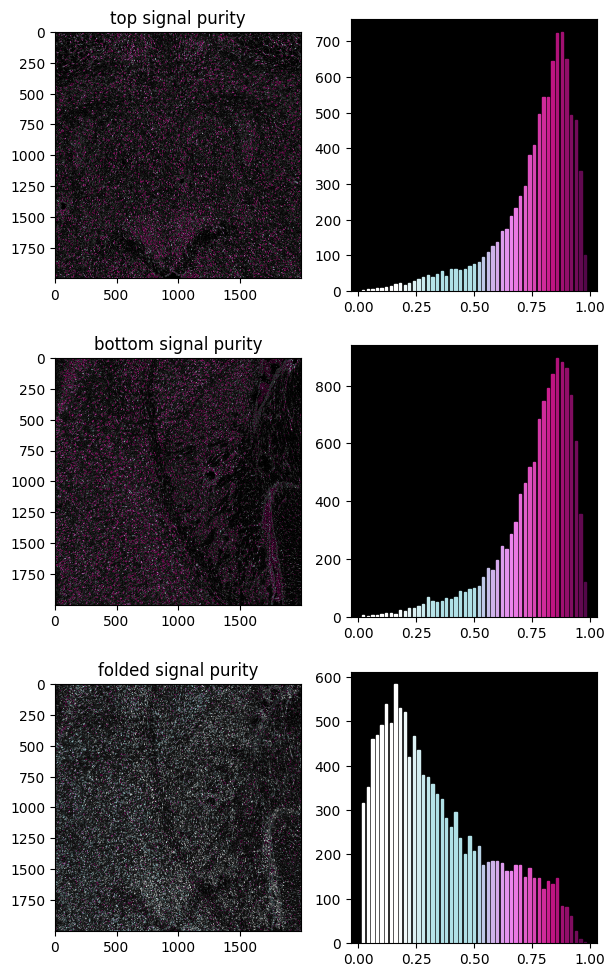

In [115]:
from ovrlpy._utils import _compute_divergence_patched  
from ovrlpy._ovrlp import _BIH_CMAP as cmap

ovrlpy.pre_process_coordinates(fold_df_bottom)
ovrlpy.pre_process_coordinates(fold_df_top)
ovrlpy.pre_process_coordinates(fold_df_folded)

min_expression = 1.5

coherence_bottom, signal_bottom = _compute_divergence_patched(fold_df_bottom, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_top, signal_top = _compute_divergence_patched(fold_df_top, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_folded, signal_folded = _compute_divergence_patched(fold_df_folded, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

def plot_purity_distribution(coherence,ax=None):
    if ax is None:
        ax = plt.gca()
    vals,bins = np.histogram(coherence, bins=50, range=(0,1))
    colors = cmap(bins[1:-1])
    bars = ax.bar(bins[1:-1],vals[1:],width=0.01)
    for i,bar in enumerate(bars):
        bar.set_color(colors[i])

fig = plt.figure(figsize=(7,12))

ax = plt.subplot(321,facecolor='k')
plt.title('top signal purity')
plt.imshow(coherence_bottom.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_bottom.T/signal_bottom.max(), interpolation='nearest')
ax = plt.subplot(322,facecolor='k')
plot_purity_distribution(coherence_bottom[fold_bottom_centroids.x,fold_bottom_centroids.y],ax=ax)

ax = plt.subplot(323,facecolor='k')
plt.title('bottom signal purity')
plt.imshow(coherence_top.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_top.T/signal_top.max(), interpolation='nearest')
ax = plt.subplot(324,facecolor='k') 
plot_purity_distribution(coherence_top[fold_top_centroids.x,fold_top_centroids.y],ax=ax)


ax = plt.subplot(325,facecolor='k')
plt.title('folded signal purity')
plt.imshow(coherence_folded.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_folded.T/signal_folded.max(), interpolation='nearest')
ax = plt.subplot(326,facecolor='k')
plot_purity_distribution(coherence_folded[fold_top_centroids.x,fold_top_centroids.y],ax=ax)



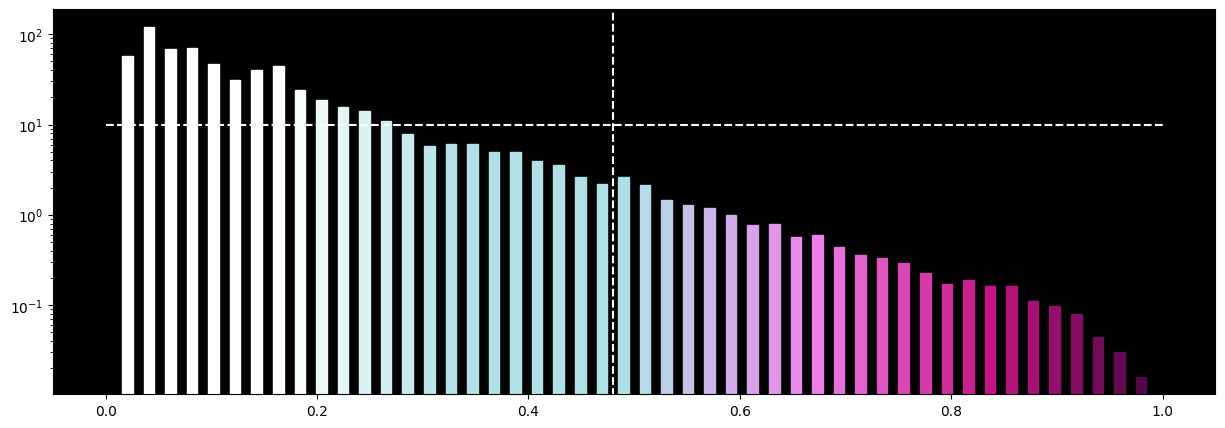

In [116]:
hist_top, bins,  = np.histogram(coherence_top[fold_top_centroids.x,fold_top_centroids.y],bins=np.linspace(0,1,50),density=True)
hist_folded, bins,  = np.histogram(coherence_folded[fold_top_centroids.x,fold_top_centroids.y],bins=np.linspace(0,1,50),density=True)
hist_quotient = hist_folded/hist_top

plt.figure(figsize=(15,5))

ax = plt.subplot(111,facecolor='k')
colors = cmap(bins[1:-1])
bars = ax.bar(bins[1:-1],hist_quotient[1:],width=0.01)
for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    
ax.set_yscale('log')
plt.hlines(10,0,1,linestyles='dashed',color='w')
plt.vlines(0.48,0,500,linestyles='dashed',color='w')